<a href="https://colab.research.google.com/github/giacomomasier/machine_learning_course/blob/python3/Forest%2C_Features_and_LightGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dimostrazione di valutazione dell'importanza delle feature selezionate nella foresta
## Confronto tra classificazione ad albero singolo, random forest e LightGBM


Import SciKit Tree Library and LightGBM Library

In [0]:
from sklearn import tree
import pandas
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb # Microsoft lightGBM install with: conda install -c conda-forge lightgbm

My functions to do OHE and do feature engineering on Titanic

In [0]:
def cat_to_num(data):
    categories = np.unique(data)
    features = {}
    for cat in categories:
        binary = (data == cat)
        features["%s=%s" % (data.name, cat)] = binary.astype("int")
    return pandas.DataFrame(features)
    
def prepare_data(data):
    """Takes a dataframe of raw data and returns ML model features
    """
    
    # Initially, we build a model only on the available numerical values
    features = data.drop(["PassengerId", "Survived", "Fare", "Name", "Sex", "Ticket", "Cabin", "Embarked"], axis=1)
    
    # Setting missing age values to -1
    features["Age"] = data["Age"].fillna(-1)
    
    # Adding the sqrt of the fare feature
    features["sqrt_Fare"] = np.sqrt(data["Fare"])
    
    # Adding gender categorical value
    features = features.join( cat_to_num(data['Sex']))
    
    # Adding Embarked categorical value
    features = features.join( cat_to_num(data['Embarked'].fillna("")) )
    
    
    return features


Load, split, prepare data

In [0]:
data = pandas.read_csv("https://raw.githubusercontent.com/thimotyb/real-world-machine-learning/master/data/titanic.csv")
data_train = data[:int(0.8*len(data))]
data_test = data[int(0.8*len(data)):]


features = prepare_data(data_train)

In [0]:
features

,Pclass,Age,SibSp,Parch,sqrt_Fare,Sex=female,Sex=male,Embarked=,Embarked=C,Embarked=Q,Embarked=S
0,3,22.0,1,0,2.692582,0,1,0,0,0,1
1,1,38.0,1,0,8.442944,1,0,0,1,0,0
2,3,26.0,0,0,2.815138,1,0,0,0,0,1
3,1,35.0,1,0,7.286975,1,0,0,0,0,1
4,3,35.0,0,0,2.837252,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
707,1,42.0,0,0,5.127134,0,1,0,0,0,1
708,1,22.0,0,0,12.310565,1,0,0,0,0,1
709,3,-1.0,1,1,3.904587,0,1,0,1,0,0
710,1,24.0,0,0,7.035922,1,0,0,1,0,0


## First Model: Using a Single Tree Classifier

In [45]:
model = tree.DecisionTreeClassifier(max_depth = 4)
model.fit(features, data_train["Survived"])
print(model.score(prepare_data(data_train), data_train["Survived"]))
model.score(prepare_data(data_test), data_test["Survived"])

0.8117977528089888


0.8212290502793296

## Second Model: Using a Random Forest

In [46]:
from sklearn import ensemble # RF is an ensemble category of model
forest = ensemble.RandomForestClassifier(n_estimators=5000, bootstrap=True, max_features="sqrt")
forest.fit(features, data_train["Survived"])
print(forest.score(prepare_data(data_train), data_train["Survived"]))
forest.score(prepare_data(data_test), data_test["Survived"])

0.9817415730337079


0.8100558659217877

Si possono anche richiedere le predizioni in formato probabilistico, per settare la soglia di conversione del falso/vero positivo

In [47]:
forest_predict_proba=forest.predict_proba(prepare_data(data_test))
forest_predict_proba[:20]

array([[0.8868    , 0.1132    ],
       [0.3512    , 0.6488    ],
       [0.90632619, 0.09367381],
       [0.99284333, 0.00715667],
       [0.006     , 0.994     ],
       [0.17128333, 0.82871667],
       [0.9694    , 0.0306    ],
       [0.77686738, 0.22313262],
       [0.0062    , 0.9938    ],
       [0.9397619 , 0.0602381 ],
       [0.32505333, 0.67494667],
       [0.90463619, 0.09536381],
       [0.7098    , 0.2902    ],
       [0.99539667, 0.00460333],
       [0.2748    , 0.7252    ],
       [0.04509708, 0.95490292],
       [0.69630667, 0.30369333],
       [0.42937   , 0.57063   ],
       [0.0136    , 0.9864    ],
       [0.50099444, 0.49900556]])

Feature importance in the Random Forest

In [0]:
# Elenca e visualizza il ranking delle feature usate nelal foresta
def show_features(forest, X, y):
  importances = forest.feature_importances_

  # Calcola deviazione standard per plottare errore
  std = np.std([tree.feature_importances_ for tree in forest.estimators_],
              axis=0)
  indices = np.argsort(importances)[::-1]

  # Print the feature ranking
  print("Feature ranking:")

  for f in range(X.shape[1]):
      print("%d. feature %s (%f)" % (indices[f], features.columns[indices[f]], importances[indices[f]]))

  # Plot the feature importances of the forest
  plt.figure()
  plt.title("Feature importances")
  plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
  plt.xticks(range(X.shape[1]), indices)
  plt.xlim([-1, X.shape[1]])
  plt.show()
  

Feature ranking:
4. feature sqrt_Fare (0.269411)
1. feature Age (0.240030)
5. feature Sex=female (0.141469)
6. feature Sex=male (0.139434)
0. feature Pclass (0.081035)
2. feature SibSp (0.050898)
3. feature Parch (0.041610)
10. feature Embarked=S (0.014903)
8. feature Embarked=C (0.012716)
9. feature Embarked=Q (0.008459)
7. feature Embarked= (0.000034)


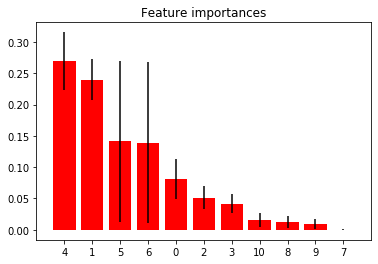

In [48]:
show_features(forest, features, data_train["Survived"])

0.9817415730337079
0.8100558659217877
Feature ranking:
4. feature sqrt_Fare (0.280407)
5. feature Sex=male (0.260350)
1. feature Age (0.244883)
0. feature Pclass (0.081296)
2. feature SibSp (0.051507)
3. feature Parch (0.042210)
9. feature Embarked=S (0.016640)
7. feature Embarked=C (0.013127)
8. feature Embarked=Q (0.009514)
6. feature Embarked= (0.000066)


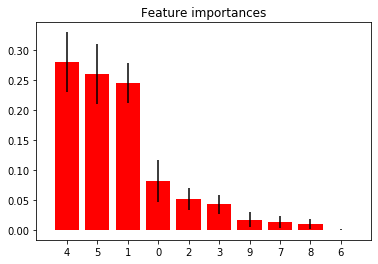

In [42]:
### prova togliendo un sesso

def prepare_data2(data):
    """Takes a dataframe of raw data and returns ML model features
    """
    
    # Initially, we build a model only on the available numerical values
    features = data.drop(["PassengerId", "Survived", "Fare", "Name", "Sex", "Ticket", "Cabin", "Embarked"], axis=1)
    
    # Setting missing age values to -1
    features["Age"] = data["Age"].fillna(-1)
    
    # Adding the sqrt of the fare feature
    features["sqrt_Fare"] = np.sqrt(data["Fare"])
    
    # Adding gender categorical value
    features = features.join( cat_to_num(data['Sex']))
    
    # Adding Embarked categorical value
    features = features.join( cat_to_num(data['Embarked'].fillna("")) )
    
    features = features.drop(['Sex=female'], axis=1)
    
    return features

data = pandas.read_csv("https://raw.githubusercontent.com/thimotyb/real-world-machine-learning/master/data/titanic.csv")
data_train2 = data[:int(0.8*len(data))]
data_test2 = data[int(0.8*len(data)):]


features = prepare_data2(data_train2)

forest = ensemble.RandomForestClassifier(n_estimators=5000, bootstrap=True, max_features="sqrt")
forest.fit(features, data_train2["Survived"])
print(forest.score(features, data_train2["Survived"]))
print(forest.score(prepare_data2(data_test), data_test2["Survived"]))

show_features(forest, features, data_train2["Survived"])

Mostra gli Stimatori che sono stati usati per comporre la foresta

In [0]:
len(forest.estimators_) # Questo coincide con il numero di stimatori prodotti per popolare la foresta

10

## Classificazione con una foresta più grande

In [43]:
extraforest = ensemble.ExtraTreesClassifier(n_estimators=10000, bootstrap=True)
extraforest.fit(features, data_train["Survived"])
print(extraforest.score(prepare_data(data_train), data_train["Survived"]))
extraforest.score(prepare_data(data_test), data_test["Survived"])

ValueError: ignored

Feature ranking:
4. feature sqrt_Fare (0.233477)
1. feature Age (0.226867)
6. feature Sex=male (0.153349)
5. feature Sex=female (0.137785)
0. feature Pclass (0.105691)
2. feature SibSp (0.054460)
3. feature Parch (0.050083)
10. feature Embarked=S (0.015416)
8. feature Embarked=C (0.013992)
9. feature Embarked=Q (0.008826)
7. feature Embarked= (0.000055)


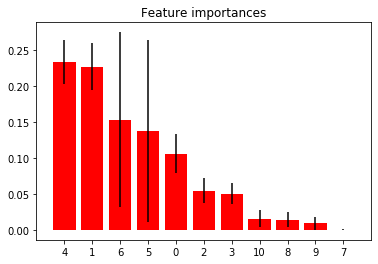

In [0]:
show_features(extraforest, features, data_train["Survived"])

## Classificazione con LightGBM

In [0]:
d_train = lgb.Dataset(features, label=data_train["Survived"])
params = {}
params['learning_rate'] = 0.003
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['sub_feature'] = 0.5
params['num_leaves'] = 10
params['min_data'] = 50
params['max_depth'] = 10
clf = lgb.train(params, d_train, 100)

In [0]:
#Prediction
y_pred=clf.predict(prepare_data(data_test))
#convert into binary values

threshold = .45   # setting threshold

for i in range(0,len(y_pred)):
    if y_pred[i]>=threshold:       
       y_pred[i]=1
    else:  
       y_pred[i]=0

In [0]:
data_test["Survived"]
y_pred

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

By definition a confusion matrix  is such that Ci,j is equal to the number of observations known to be in group i but predicted to be in group j.

Thus in binary classification, the count of true negatives is C0,0 , false negatives is C1,0, true positives is C1,1 and false positives is C0,1.

In [0]:
#Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(data_test["Survived"], y_pred)
#Accuracy
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_pred,data_test["Survived"])

In [0]:
print("Confusion Matrix:")
print(cm)
print("Model Accuracy: {0}".format(accuracy))

Confusion Matrix:
[[115   0]
 [ 64   0]]
Model Accuracy: 0.6424581005586593
